# Protein folding 
Using our implementation of the AMBER forcefield for protein folding. 
Currently, it lacks water. 


## Todo 
1. GNN sims
2. CG sims
3. add water 

In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [4]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

In [5]:
pdb_id = '2WXC' # '2JOF' # '5AWL'

pdb_dir = '../data/pdb/'
os.makedirs(pdb_dir, exist_ok=True) 

pdb_file = os.path.join(pdb_dir, pdb_id+'.pdb')

# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    pdb_file = pf.download_pdb_file(pdb_id, dir = pdb_dir)
    
prot = pf.Protein(pdb_file)


In [6]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
# modeller.addSolvent(forcefield, model="tip3p", padding=.05 * unit.nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [7]:
system.getNumParticles(), system.getNumForces()

(711, 5)

In [128]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10 # 10x to go from nm to angstrom

pdb_orig_file = os.path.join(pdb_dir, f'orig-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_orig_file , 'w'))

In [129]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
p_.addModel(pf.get_file_text(pdb_file), 'pdb')
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


In [11]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Energy Minimization

In [19]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e0 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [20]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
pdb_energy

125772.375

## Starting from PDB positions

In [21]:
# define the initial position
initial_pos = x = prot.node_positions.to(DEVICE)

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n711_d3


In [20]:
h = energy_minimizer.train(10000)

Early stopping at step 2880


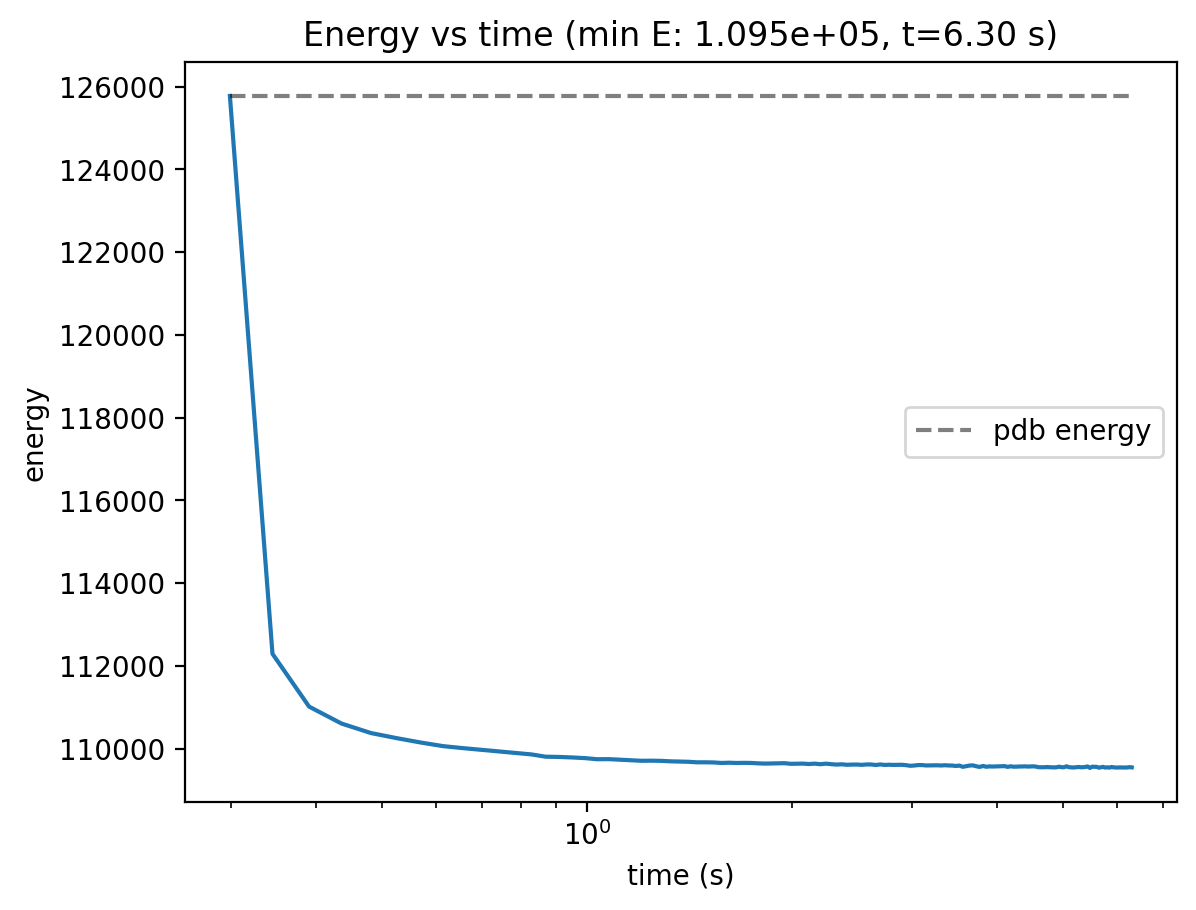

In [21]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [22]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.6219, 0.7157, 0.5568], device='cuda:0', grad_fn=<StdBackward0>)

In [23]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [24]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [25]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Starting from Random Init

In [26]:
# define the initial position
x = torch.randn_like(prot.node_positions)
# scale x to have std = s*std of original positions
x = x * 1.5 * prot.node_positions.std(dim=0)
x = x.to(DEVICE)
initial_pos = x

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n711_d3


In [27]:
# h = energy_minimizer.train(10000)

In [28]:
# len(h['time']), len(energy_minimizer.history['time'])

In [29]:
# I want to compute what my LR decay rate should be to reach a certain value after N epochs
LR0 = 1e-2
N = 200
LR_decay = (2e-3/LR0)**(1/N)

from torch.optim.lr_scheduler import ExponentialLR

# Decay LR by a factor of 0.96 every epoch
scheduler = ExponentialLR(energy_minimizer.optimizer, gamma=LR_decay)

LR_decay

0.9919851023898785

In [30]:

for epoch in range(100):
    h = energy_minimizer.train(200)
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.4g}, time: {np.sum(h["time"]):.2f} s', end = '\r') 
    
    # Step the scheduler
    scheduler.step()
    # break

In [31]:

for epoch in range(100):
    h = energy_minimizer.train(200)
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.4g}, time: {np.sum(h["time"]):.2f} s', end = '\r') 
    
    # Step the scheduler
    # scheduler.step()
    # break

Text(0.5, 1.0, 'Energy vs time (min E: 1.097e+05, t=37.75 s)')

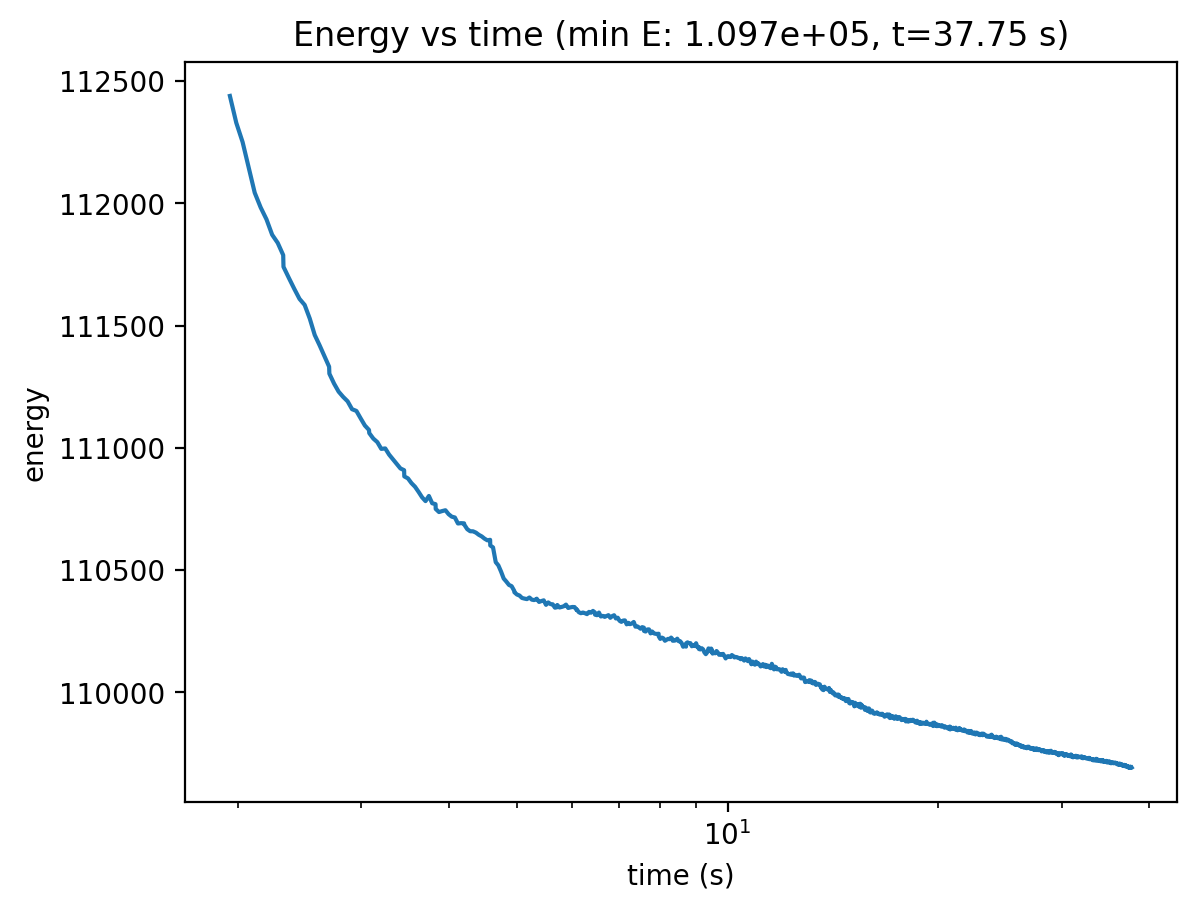

In [31]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 50

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [32]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.6031, 0.5221, 0.5958], device='cuda:0', grad_fn=<StdBackward0>)

In [33]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [34]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [36]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [110]:
# prot.harmonic_bond_data['equilibrium_length']

# GNN

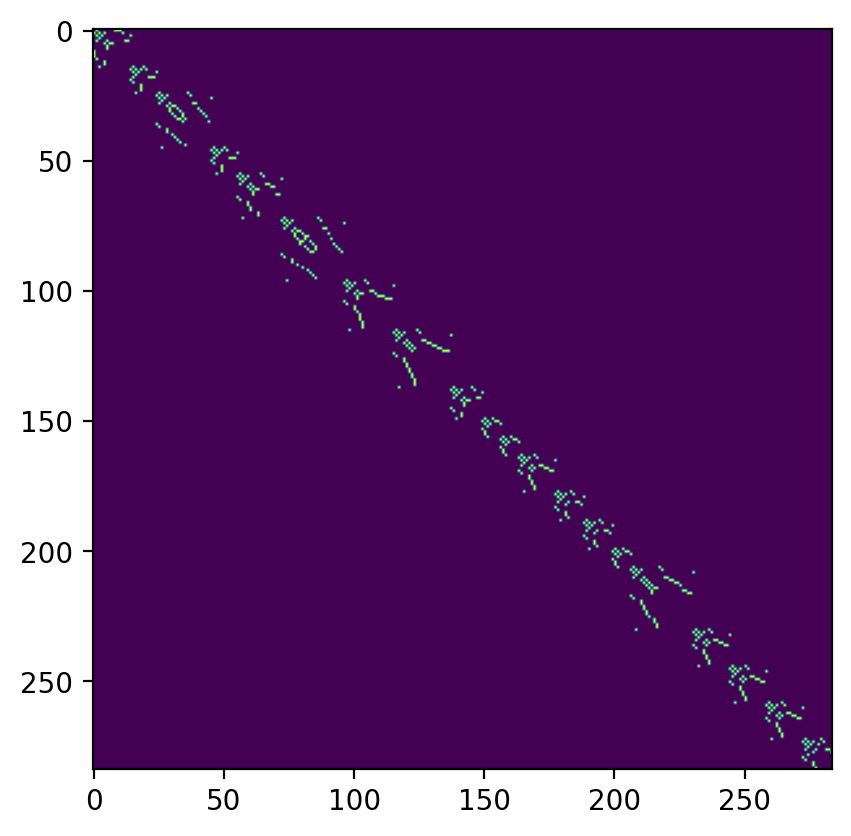

In [37]:
plt.imshow(V(prot.adjacency_matrix))

In [12]:
# to initialize random positions, we can 
# estimate the average volume occupied by each atom
# when the atoms are in a regular grid with
# the same distance between them. 
# we set this distance to 1.5A (average bond length)

# the volume occupied by each atom is a sphere with radius 1.5A
r0 = 0.15 # nm
v0 = 4/3*np.pi*r0**3
# total volume occupied by all atoms
vn = len(prot.node_positions)*v0
init_radius = (vn*3/4/np.pi)**(1/3)
init_radius


1.3387961639331505

In [22]:
# Define an annealing scheduler
from torch.optim.lr_scheduler import ExponentialLR

class AnnealingLR(ExponentialLR):
    def __init__(self, optimizer, lr_min, lr_max, epochs, last_epoch=-1):
        self.epochs = epochs
        self.epoch_counter = 0 # we use this to know when to stop decaying the LR
        self.get_decay_rate(lr_min, lr_max, epochs)
        super(AnnealingLR, self).__init__(optimizer, self.gamma, last_epoch)
    
    def get_decay_rate(self, lr_min, lr_max, epochs):
        self.gamma = (lr_min/lr_max)**(1/epochs)
    
    # we can redefine step to change the learning rate only before "epochs" epochs
    def step(self):
        if self.epoch_counter < self.epochs:
            self.epoch_counter += 1
            super(AnnealingLR, self).step()
        else:
            pass

In [23]:
MIN_DELTA = 1e-1
PATIENCE = 10
DEVICE = 'cuda'

In [112]:
from coarsegrainer.GNN import GNNReparam

# hidden dimension
h = 300
A = prot.adjacency_matrix.to(DEVICE)
n = len(A)
d = 3
init_scaling = 3 #1.5
gnn_reparam = GNNReparam([h, h//1, h//1, d], A=A,
                        bias=True, activation=torch.nn.Tanh(), output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

gnn_minimizer = GNNMinimizer(energy, initial_pos, gnn_reparam, optimizer_type='Adam',
    lr=4e-3, lr_gnn=1e-4,
    # lr=1e-3, lr_gnn=1e-3,
    # lr=2*LR, lr_gnn=4e-3,
    clamp_grads=1e-2, log_step=20, log_pos_step=0, 
    log_dir='../results/logs', log_name=f'GNN_protein_{pdb_id}_',
    patience=PATIENCE, min_delta=MIN_DELTA, 
    gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e0)


std after rescaling 4.02
Using Adam optimizer
Log name: GNN_protein_2WXC_
Logging to: ../results/logs/GNN_protein_2WXC__n711_d3
Using Adam optimizer


In [113]:
(gnn_reparam().std(), gnn_minimizer.get_x().std())

(tensor(4.0169, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(4.0169, device='cuda:0', grad_fn=<StdBackward0>))

In [114]:
N = 50
drop_rate = 10
annealer_gnn = AnnealingLR(gnn_minimizer.optimizer_gnn, 
                    lr_max=gnn_minimizer.lr_gnn, 
                    lr_min=gnn_minimizer.lr_gnn/drop_rate, 
                    epochs=N)

annealer_fg = AnnealingLR(gnn_minimizer.optimizer_fg, 
                    lr_max=gnn_minimizer.lr, 
                    lr_min=gnn_minimizer.lr/drop_rate, 
                    epochs=N)

In [115]:
relax_counter = 10
for epoch in range(2*N):
    h = gnn_minimizer.train(300)
    # also print the current lr
    
    c = gnn_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.4g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    
    if not gnn_minimizer.fine_grained:
        annealer_gnn.step()
        print(f'GNN lr: {annealer_gnn.get_last_lr()[0]:.2e}', end = '\r')
    else:
        annealer_fg.step()
        print(f'FG lr: {annealer_fg.get_last_lr()[0]:.2e}', end = '\r')
        
    if gnn_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 22005, time: 15.98 s, pat:1, GNN lr: 3.80e-05
Starting fine-graining


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Early stopping at step 20005, time: 18.39 s, pat:0, FG lr: 5.23e-03
epoch: 24, energy: 1.101e+05, time: 18.82 s, pat:10, FG lr: 4.99e-03
relaxing 9
Early stopping at step 24005, time: 19.43 s, pat:7, FG lr: 4.77e-03
epoch: 26, energy: 1.101e+05, time: 19.94 s, pat:10, FG lr: 4.55e-03
relaxing 8
Early stopping at step 22005, time: 21.75 s, pat:8, FG lr: 3.96e-03
epoch: 30, energy: 1.101e+05, time: 22.22 s, pat:10, FG lr: 3.79e-03
relaxing 7
Early stopping at step 260
epoch: 31, energy: 1.101e+05, time: 22.77 s, pat:10, FG lr: 3.62e-03
relaxing 6
Early stopping at step 20005, time: 25.79 s, pat:3, FG lr: 2.87e-03
epoch: 37, energy: 1.101e+05, time: 26.22 s, pat:10, FG lr: 2.74e-03
relaxing 5
Early stopping at step 200, time: 27.43 s, pat:9, FG lr: 2.50e-0303
epoch: 40, energy: 1.1e+05, time: 27.87 s, pat:10, FG lr: 2.39e-03
relaxing 4
Early stopping at step 240, time: 28.47 s, pat:0, FG lr: 2.28e-03
epoch: 42, energy: 1.101e+05, time: 28.99 s, pat:10, FG lr: 2.18e-03
relaxing 3
Early sto

In [99]:
# gnn_minimizer.start_fine_graining()

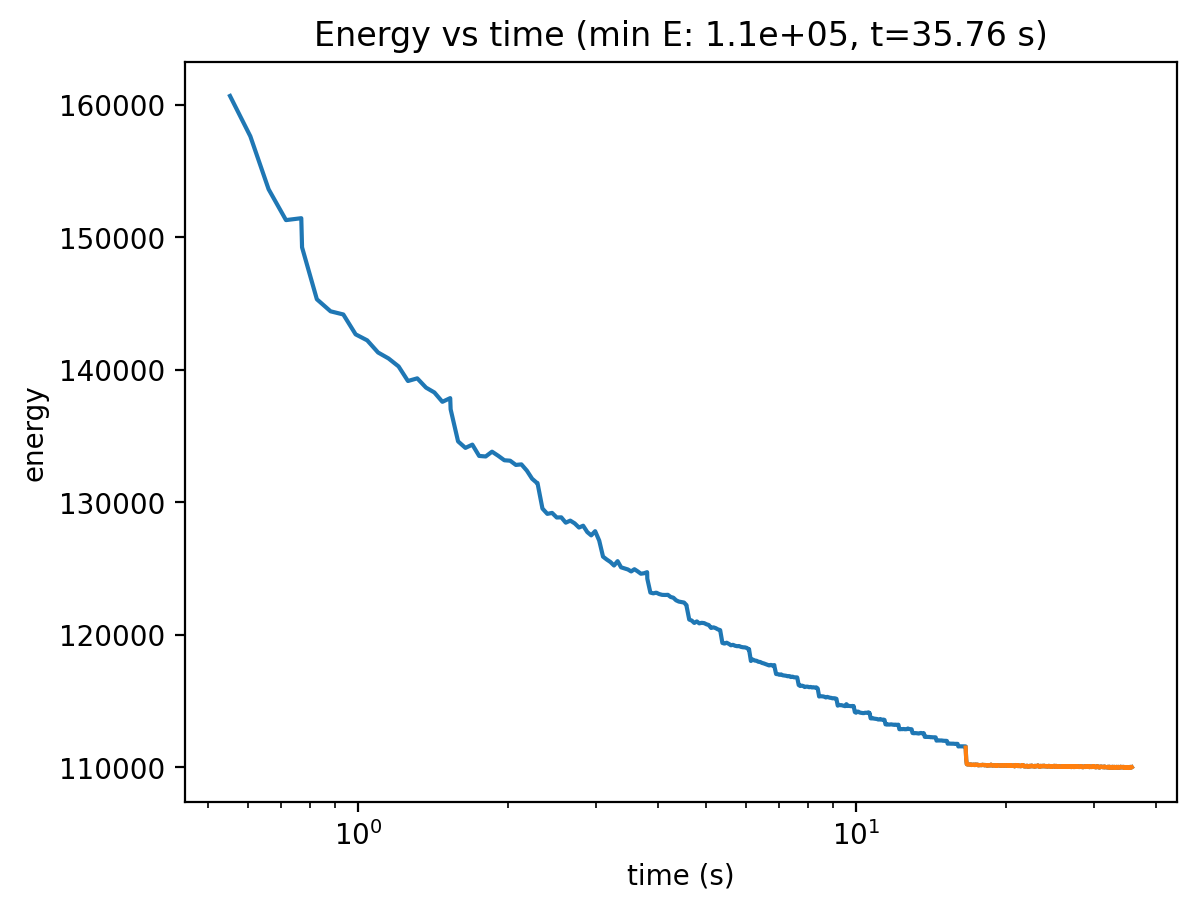

In [116]:
gnn_minimizer.plot_history(start=10)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')
plt.yscale('linear')


In [117]:
xf = gnn_minimizer.get_x()
xf.std(dim=0)

tensor([0.5506, 0.6536, 0.5814], device='cuda:0', grad_fn=<StdBackward0>)

In [118]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-GNN-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [119]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [120]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# RMSD

In [131]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [134]:
pdb_orig_file, pdb_test_file

('../data/pdb/orig-2WXC.pdb', './test-GNN-2WXC.pdb')

In [135]:
from Bio.PDB import PDBParser, Superimposer

# Parse the structures
parser = PDBParser()
structure1 = parser.get_structure(f"orig-{pdb_id}", pdb_orig_file)
structure2 = parser.get_structure(f"GNN-{pdb_id}", pdb_test_file)

# Get the atoms from each structure
atoms1 = list(structure1.get_atoms())
atoms2 = list(structure2.get_atoms())

# Make sure the two proteins have the same number of atoms
assert len(atoms1) == len(atoms2), "Proteins have different numbers of atoms"

# Create a Superimposer object
super_imposer = Superimposer()

# Apply the superimposition on the atom coordinates
super_imposer.set_atoms(atoms1, atoms2)

# Print the RMSD
print("RMSD:", super_imposer.rms)

RMSD: 11.425770775058448


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 715
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 715
  warnings.warn(


In [146]:
from Bio.PDB import PDBIO

# Apply the rotation and translation to the second structure
super_imposer.apply(structure2.get_atoms())

# Write the superimposed structure to a new PDB file
io = PDBIO()
# io.set_structure(structure1)
# pdb_orig_file = f'./superimposed-GNN-{pdb_id}.pdb'
# io.save(pdb_superimposed_file)
io.set_structure(structure2)
pdb_superimposed_file = os.path.join(pdb_dir, f'superimposed-GNN-{pdb_id}.pdb')
io.save(pdb_superimposed_file)

In [143]:
import py3Dmol

# Read the PDB file
with open(pdb_superimposed_file, "r") as f: 
    pdb_super = f.read()
with open(pdb_orig_file, "r") as f: 
    pdb_orig = f.read()

# Create a viewer and add the structure
viewer = py3Dmol.view()
viewer.addModel(pdb_super, "pdb")
viewer.addModel(pdb_orig, "pdb")

# Set some display options
# viewer.setStyle({'stick': {}})
# display the protein as a cartoon
# viewer.setStyle({'cartoon': {'color':'spectrum'}})
viewer.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})  # original structure in blue
viewer.setStyle({'model': 1}, {'cartoon': {'color': 'spectrum', 'opacity': 0.6}})  # superimposed structure in semi-transparent red

viewer.zoomTo()

# Show the viewer
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [145]:
import py3Dmol

# Read the PDB file
with open(pdb_superimposed_file, "r") as f: 
    pdb_super = f.read()
with open(pdb_orig_file, "r") as f: 
    pdb_orig = f.read()

# Create a viewer and add the structure
viewer = py3Dmol.view()
viewer.addModel(pdb_super, "pdb")
viewer.addModel(pdb_orig, "pdb")

# Set some display options
# viewer.setStyle({'stick': {}})
# display the protein as a cartoon
# viewer.setStyle({'cartoon': {'color':'spectrum'}})
viewer.setStyle({'model': 0}, {'stick': {'color': 'blue'}})  # original structure in blue
viewer.setStyle({'model': 1}, {'stick': {'color': 'red', 'opacity': 0.6}})  # superimposed structure in semi-transparent red

viewer.zoomTo()

# Show the viewer
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.